In [507]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [1001]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = (Z > 0.5).astype(int).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()



def plot_decision_boundary_one_hot(model, X, y, resolution=0.02):
    # Define the color maps
    markers = ('s', 'x', 'o', '^', 'v', '+', 'p', 'd', 'h', '8', '<', '>')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(np.argmax(y, axis=1)))])

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Flatten the grid to pass it through the model
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict class probabilities for each point in the mesh grid
    Z = model.forward(grid)
    
    # Convert probabilities to class labels
    Z = np.argmax(Z, axis=1)
    
    # Reshape the results to match the mesh grid
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot the data points
    for idx, cl in enumerate(np.unique(np.argmax(y, axis=1))):
        plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0], 
                    y=X[np.argmax(y, axis=1) == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    plt.legend(loc='upper left')
    plt.show()

# Example usage
# Assuming you have a trained model and data X, y
# model = ... # Your trained model
# X = ...     # Your input features
# y = ...     # Your one-hot encoded labels


Gradient descent

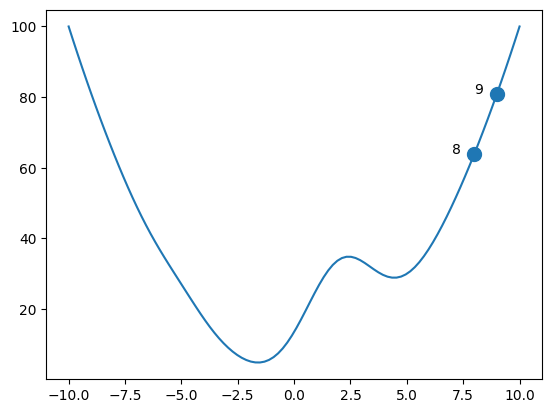

In [3]:
def sphere_2D(x):
    return x**2

def sphere_with_holes(x):
    return x**2 + 30*np.exp(-0.2*(x-2)**2) + 2*np.exp(-0.5*(x+5)**2)

def rasstrigin_2D(x):
    return x**2 - 22*np.cos(2*np.pi*x) + 20

def min_fn(x):
    return sphere_with_holes(x)

x_min = -10
x_max = 10

def plot_curve():
    x_sp = np.linspace(x_min, x_max, 100)
    y_sp = min_fn(x_sp)
    plt.plot(x_sp, y_sp)

def sp(x_p):
    plot_curve()

    plt.scatter([x_p],min_fn(x_p), s=200)
    plt.show()

def sp_many(x):
    plot_curve()

    plt.scatter(x,[min_fn(x) for x in x], s=100)
    for x in x:
        plt.text(x - 1, min_fn(x), x)


sp_many([8, 9])



In [4]:
x_train = np.array([
    [1, 1],
    [0, 1],
    [1, 0],
    [0, 0],
])

y_train = np.array([
    [1],
    [0],
    [0],
    [0],
])

# y_train = np.array([
#     [0],
#     [1],
#     [1],
#     [0],
# ])

# np.random.seed(0)

class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs

    def __init__(self, inputs_len, neurons_len, activation=relu):
        self.weights = np.random.rand(inputs_len, neurons_len)
        self.biases = np.zeros(neurons_len)
        self.activation = activation

    def forward(self, inputs):
        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)



class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            layer.forward(inputs)
            inputs = layer.output

    def fit(self, inputs, targets, lp=0.01, n_iter=10):
        for _ in range(n_iter):
            print(f'iter {_}')
            for input, target in zip(inputs, targets):
                self.updateWeightsBiases(input, target, lp)

    def updateWeightsBiases(self, input, target, lp):
        self.forward(input)
        loss = self.calculate_loss(target)
        print(f'loss {loss}')

        for layer in self.layers:
            for i in range(len(layer.weights)):
                layer.weights[i] = layer.weights[i] + lp * loss * input[i]

            layer.biases = layer.biases + lp * loss 

    def calculate_loss(self, target):
        # return np.mean((target - self.output)**2)
        return target - self.layers[-1].output
    
    def predict(self, inputs):
        self.forward(inputs)
        return self.layers[-1].output


mlp = NeuralNetwork()


mlp.add(LayerDense(2, 1, LayerDense.heaviside))





In [6]:
mlp.fit(x_train, y_train, 0.1, 3)

iter 0
loss [0.]
loss [-1.]
loss [0.]
loss [0.]
iter 1
loss [1.]
loss [-1.]
loss [0.]
loss [0.]
iter 2
loss [0.]
loss [0.]
loss [0.]
loss [0.]


In [7]:
mlp.layers[0].weights

array([[0.15367981],
       [0.43611684]])

In [2231]:
mlp.layers[0].output

array([0.])

In [8]:
plot_decision_boundary(mlp, x_train, y_train)

TypeError: '>' not supported between instances of 'NoneType' and 'float'

backpropagation

In [11]:
def df(f, a):
    h = 0.0001
    return ( f(a + h) - f(a) ) / h

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def df_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [12]:
df(LayerDense.relu, 4)

0.9999999999976694

In [987]:
np.random.seed(0)

class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs
    
    # @staticmethod
    # def softmax(x):
    #     exp_x = np.exp(x - np.max(x)) 
        
    #     return exp_x / np.sum(exp_x)
    
    def df_activation(self, activated_output):
        """
            activated_output -> aL = σ(zL)
        """

        if self.activation == LayerDense.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerDense.relu:
            return np.where(activated_output <= 0, 0, 1)
        elif self.activation == LayerDense.softmax:
            batch_size = activated_output.shape[0]
            # Initialize the tensor for storing the derivatives
            d_softmax = np.zeros((batch_size, activated_output.shape[1], activated_output.shape[1]))
            for i in range(batch_size):
                s = activated_output[i].reshape(-1, 1)
                d_softmax[i] = np.diagflat(s) - np.dot(s, s.T)

            return d_softmax


    def __init__(self, inputs_len, neurons_len, activation=relu):
        self.weights = np.random.randn(inputs_len, neurons_len)
        # print(self.weights)
        self.biases = np.zeros(neurons_len)
        self.activation = activation

    def forward(self, inputs):
        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)
        return self.output



class NeuralNetwork:
    @staticmethod
    def loss_mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    @staticmethod
    def df_loss_mse(y_true, y_pred):
        return y_pred - y_true
    
    @staticmethod
    def loss_binary_crossentropy(y_true, y_pred):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        return -np.mean(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
    
    @staticmethod
    def loss_categorical_crossentropy(y_true, y_pred):
        epsilon = 1e-10
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        return -np.mean(y_true * np.log(y_pred))

    def __init__(self, loss=loss_mse):
        self.loss = loss
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            layer.forward(inputs)
            inputs = layer.output

        return inputs
    
    def calculate_output_delta(self, layer, y_true, y_pred):
        if layer.activation == LayerDense.softmax:
            return y_pred - y_true
        if layer.activation == LayerDense.sigmoid:
            grad_loss_input = self.df_loss_mse(y_true, y_pred) # derivative of loss function = ∇aL | samples -> neurons
            activation_derivative = layer.df_activation(layer.output) # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) | samples -> neurons

            return grad_loss_input * activation_derivative # δL = ∇aL * σ'(zL) | samples -> neurons

    def backward_auto(self, inputs, y_true, y_pred, lp, batch_size):
        layers_count = len(self.layers)

        for layer_index in reversed(range(0, layers_count)):
            layer = self.layers[layer_index]

            is_output_layer = layer_index == layers_count - 1
            
            if is_output_layer:
                # output layer
                layer.delta = self.calculate_output_delta(layer, y_true, y_pred)
            else:
                prev_backward_layer = self.layers[layer_index + 1]        

                layer.propagated_error = np.dot(prev_backward_layer.delta, prev_backward_layer.weights.T) # δL * wL.T

                layer.activation_derivative = layer.df_activation(layer.output) 
                layer.delta = layer.propagated_error * layer.activation_derivative

            if layer_index != 0:
                next_backward_layer = self.layers[layer_index - 1]

                next_backward_layer_output = next_backward_layer.output.T
            else:
                next_backward_layer_output = inputs.T

            layer.grad_loss_weights = np.dot(next_backward_layer_output, layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
            layer.grad_loss_biases = np.sum(layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

            layer.weights = layer.weights - lp * layer.grad_loss_weights / batch_size
            layer.biases = layer.biases - lp * layer.grad_loss_biases / batch_size

    def test_backward_2_layers_only(self, inputs, y_true, y_pred, lp, batch_size):
        output_layer = self.layers[1]
        
         # derivative of loss function df_loss
         # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) df_activation
        
        # print(self.df_loss(y_true, y_pred))

        output_delta = self.df_loss_mse(y_true, y_pred) * output_layer.df_activation(output_layer.output) # ∇aL * σ'(zL) | for sigmoid output layer
        # output_delta = y_pred - y_true 
        
        hidden_layer = self.layers[0]
        
        vw_loss_output = np.dot(hidden_layer.output.T, output_delta) # ∇wL = aL-1.T * δL
        vb_loss_output = np.sum(output_delta, axis=0, keepdims=True) # ∇bL = δL
        # print('weight',output_layer.weights)
        # print('vw_loss_output', vw_loss_output)
        # print('----------------------------------------')

        output_layer.weights = output_layer.weights - lp * vw_loss_output / batch_size
        output_layer.biases = output_layer.biases - lp * vb_loss_output / batch_size
        
        # next prev layer

        activated_weights_from_output_to_hidden = output_layer.weights.T
        hidden_error = np.dot(output_delta, activated_weights_from_output_to_hidden) # δL * wL.T

        hidden_derivative_activated = hidden_layer.df_activation(hidden_layer.output) 
        hidden_delta = hidden_error * hidden_derivative_activated

        vw_loss_hidden = np.dot(inputs.T, hidden_delta)
        vb_loss_hidden = np.sum(hidden_delta, axis=0, keepdims=True)

        hidden_layer.weights = hidden_layer.weights - lp * vw_loss_hidden / batch_size
        hidden_layer.biases = hidden_layer.biases - lp * vb_loss_hidden / batch_size


    def fit(self, inputs, y_true, lp=0.01, epochs=10, batch_size=10, validation_split=0.1):
        print(f'Total iterations {epochs * (math.ceil(len(inputs) / batch_size))}')
        print(f'Iterations of each epoch {math.ceil(len(inputs) / batch_size)}')

        x_val = inputs[-int(len(inputs) * validation_split):]
        y_val = y_true[-int(len(inputs) * validation_split):]
        x_true = inputs[:-int(len(inputs) * validation_split)]
        y_true = y_true[:-int(len(inputs) * validation_split)]

        print(f'Validation split {len(y_val)}')
        print(f'Training split {len(y_true)}')

        for epoch in range(epochs):
            print(f'Epoch: {epoch}/{epochs} | loss {self.loss(y_val, self.forward(x_val))}')

            for i in range(0, len(x_true), batch_size):
                inputs_batch = x_true[i:i+batch_size]
                y_true_batch = y_true[i:i+batch_size]

                y_hats = self.forward(inputs_batch) # y_hats -> aL = sigmoid(zL) | predicted output
                 
                self.backward_auto(inputs_batch, y_true_batch, y_hats, lp, batch_size)



<h1> Testing Blobs </h1>

<h2> Output Sigmoid (2 classes) </h2>

(480, 2) (480,)


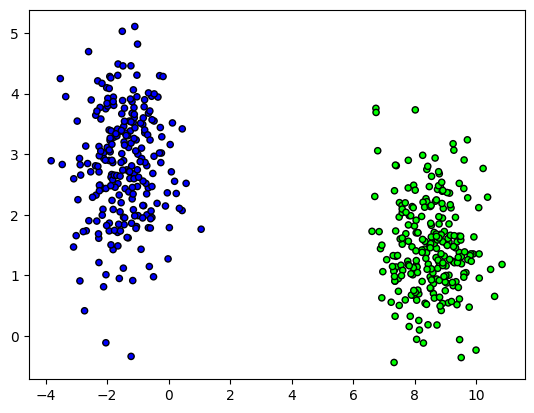

In [1028]:
n_features = 2
n_classes = 2
n_samples= 600
cluster_std = 0.8


X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=cluster_std)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20)


print(X_train.shape, y_train.shape)

In [1036]:
mlp_2 = NeuralNetwork(loss=NeuralNetwork.loss_mse)

mlp_2.add(LayerDense(n_features, 6, LayerDense.relu))
mlp_2.add(LayerDense(6, 6, LayerDense.relu))
mlp_2.add(LayerDense(6, 1, LayerDense.sigmoid))

Total iterations 48
Iterations of each epoch 48
Validation split 48
Training split 432
Epoch: 0/1 | loss 0.0005194401113546659


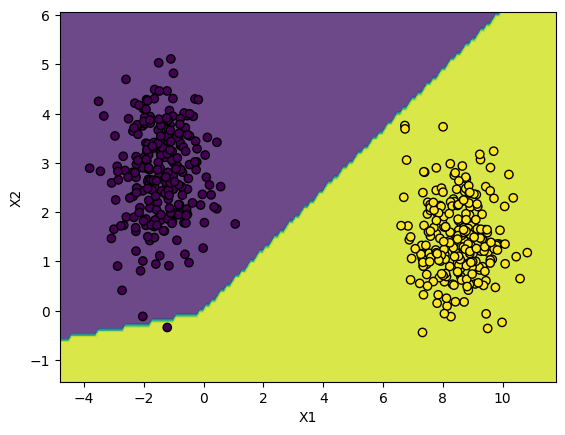

In [1064]:
reshaped_y_true = y_train.reshape(-1, 1)  # [1, 0, 0, 0] -> [[1], [0], [0], [0]] | since here we have outputs from 

mlp_2.fit(X_train, reshaped_y_true, 0.03, 100, 10)

plot_decision_boundary(mlp_2, X_train, reshaped_y_true) 

<h2> Output Softmax (n classes) </h2>

(240, 2) (240, 5)


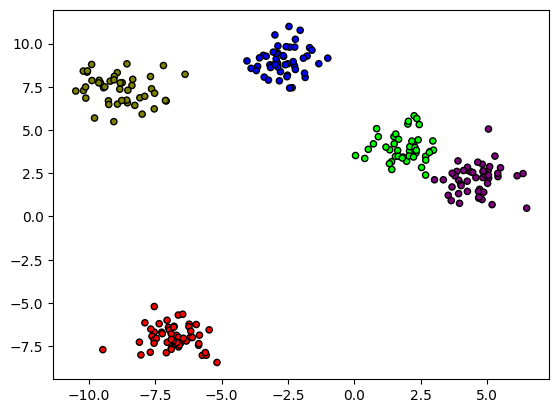

In [976]:
n_features = 2
n_classes = 5
n_samples= 300
cluster_std = 0.8


X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=cluster_std, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20)

encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

print(X_train.shape, y_train.shape)

In [977]:
mlp = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp.add(LayerDense(n_features, 4, LayerDense.relu))
mlp.add(LayerDense(4, n_classes, LayerDense.softmax))

Total iterations 3
Iterations of each epoch 3
Validation split 24
Training split 216
Epoch: 0/1 | loss 0.3471789993860109


C:\Users\ferra\AppData\Local\Temp\ipykernel_10564\1963356961.py:48: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0],


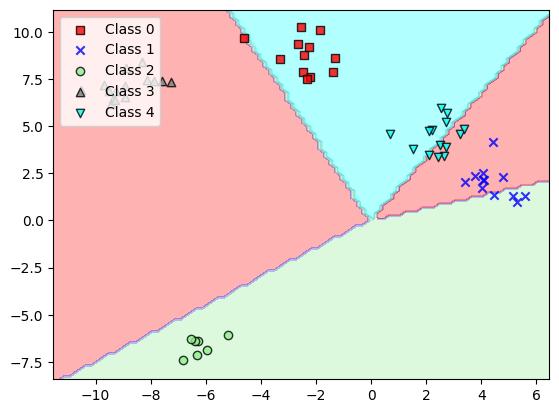

In [978]:
mlp.fit(X_train, y_train, 0.01, 1, 100)

plot_decision_boundary_one_hot(mlp, X_test, y_test, 0.2)

In [24]:
delta_3_batch_1_output = np.array(
[
     # 1 output
    [1], # sample 1
])



output_hiddeen_3_batch = np.array([
    # neuron 0 neuron 1  neuron 2  neuron 3
    [1, 2, 3, 4], # sample 1

])

# print(output_hiddeen_3_batch.T)


np.dot(delta_3_batch_1_output, output_hiddeen_3_batch) * np.array([1, 2, 3, 4])


array([[ 1,  4,  9, 16]])